In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss, roc_curve, roc_auc_score
from rpf_interpretations_feature_names import add_feature_names
import matplotlib.pyplot as plt
import matplotlib.colors as mlp
import seaborn as sns
import shap
import joblib
import re
import os

In [3]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
})

In [4]:
shap_red = shap.plots.colors.red_rgb
shap_blue = shap.plots.colors.blue_rgb
shap_gray = shap.plots.colors.gray_rgb
shap_cmap = shap.plots.colors.red_blue
shap_discrete_cmap = mlp.ListedColormap([shap_blue, shap_red])
shap_multi_discrete_map = mlp.ListedColormap([np.array(shap_cmap(a))[:-1] for a in np.linspace(0,1,4)])

In [5]:
X = pd.read_csv('data/X_large.csv')
y = np.load('data/y_new.npy')

In [6]:
(X_train, X_test, y_train, y_test) = train_test_split(X,y,test_size=0.2,random_state=42)

In [7]:
col_labels = ['Female', 'Age', 'Physical Activity', 'Serum Albumin',
       'Alkaline Phosphatase', 'SGOT', 'BUN', 'Calcium', 'Creatinine',
       'Potassium', 'Sodium', 'Total Bilirubin', 'Serum Protein',
       'Red Blood Cells', 'White Blood Cells', 'Hemoglobin', 'Hematocrit',
       'Normal Platelets', 'Increased Platelets', 'Decreased Platelets',
       'Segmented Neutrophils', 'Lymphocytes', 'Monocytes', 'Eosinophils',
       'Basophils', 'Band Neutrophils', 'Cholesterol',
       'Negative Urine Albumin', 'Urine Albumin above 30',
       'Urine Albumin above 100', 'Urine Albumin above 300',
       'Urine Albumin above 1000', 'Urine Albumin Trace',
       'Negative Urine Glucose', 'Light Urine Glucose',
       'Medium Urine Glucose', 'Dark Urine Glucose',
       'Very Dark Urine Glucose', 'Urine Glucose Trace', 'Urine pH',
       'Negative Urine Hematest', 'Urine Hematest Small',
       'Urine Hematest Moderate', 'Urine Hematest Large',
       'Urine Hematest Very Large', 'Urine Hematest Trace',
       'Sedimentation Rate', 'Uric Acid', 'Systolic BP',
       'Pulse Pressure', 'BMI']

In [8]:
RF_grid = joblib.load('Results/RF_grid.pkl')
Base_grid = joblib.load('Results/RPF_Baseline_L2_Xlarge.pkl')
os.chdir(sys.path[0])
RPF_grid = joblib.load('Results/RPF_Interactions_L2_Xlarge.pkl')
os.chdir(sys.path[0])
Base_model = joblib.load('Results/Purified_RPF_Baseline_L2_Xlarge.pkl')
RPF_model = joblib.load('Results/Purified_RPF_Interactions_L2_Xlarge.pkl')
RF_model = RF_grid.best_estimator_['randomforestclassifier']     

In [9]:
os.chdir(sys.path[0])

In [10]:
base_train_pur_pred = joblib.load('Results/train_pur_proba_L2_base.pkl')
rpf_train_pur_pred = joblib.load('Results/train_pur_proba_L2_int.pkl')

In [11]:
imputer = RF_grid.best_estimator_['imputer']
X_train_trans = imputer.transform(X_train)
X_test_trans = imputer.transform(X_test)

In [12]:
rf_fi = RF_model.feature_importances_
base_fi = Base_model.feature_importance_
rpf_fi = RPF_model.feature_importance_

In [13]:
RF_permutations = joblib.load('Results/RF_Permutations.pkl')
rf_log_loss_imp = RF_permutations['neg_log_loss'].importances
rf_log_loss_sort = np.median(rf_log_loss_imp, axis = 1).argsort()
rf_accuracy_imp = RF_permutations['accuracy'].importances
rf_accuracy_sort = np.median(rf_accuracy_imp, axis = 1).argsort()

In [14]:
Base_permutations = joblib.load('Results/RPF_Baseline_Permutations.pkl')
base_log_loss_imp = Base_permutations['neg_log_loss'].importances
base_log_loss_sort = np.median(base_log_loss_imp, axis = 1).argsort()
base_accuracy_imp = Base_permutations['accuracy'].importances
base_accuracy_sort = np.median(base_accuracy_imp, axis = 1).argsort()

In [15]:
RPF_permutations = joblib.load('Results/RPF_Interactions_Permutations.pkl')
rpf_log_loss_imp = RPF_permutations['neg_log_loss'].importances
rpf_log_loss_sort = np.median(rpf_log_loss_imp, axis = 1).argsort()
rpf_accuracy_imp = RPF_permutations['accuracy'].importances
rpf_accuracy_sort = np.median(rpf_accuracy_imp, axis = 1).argsort()

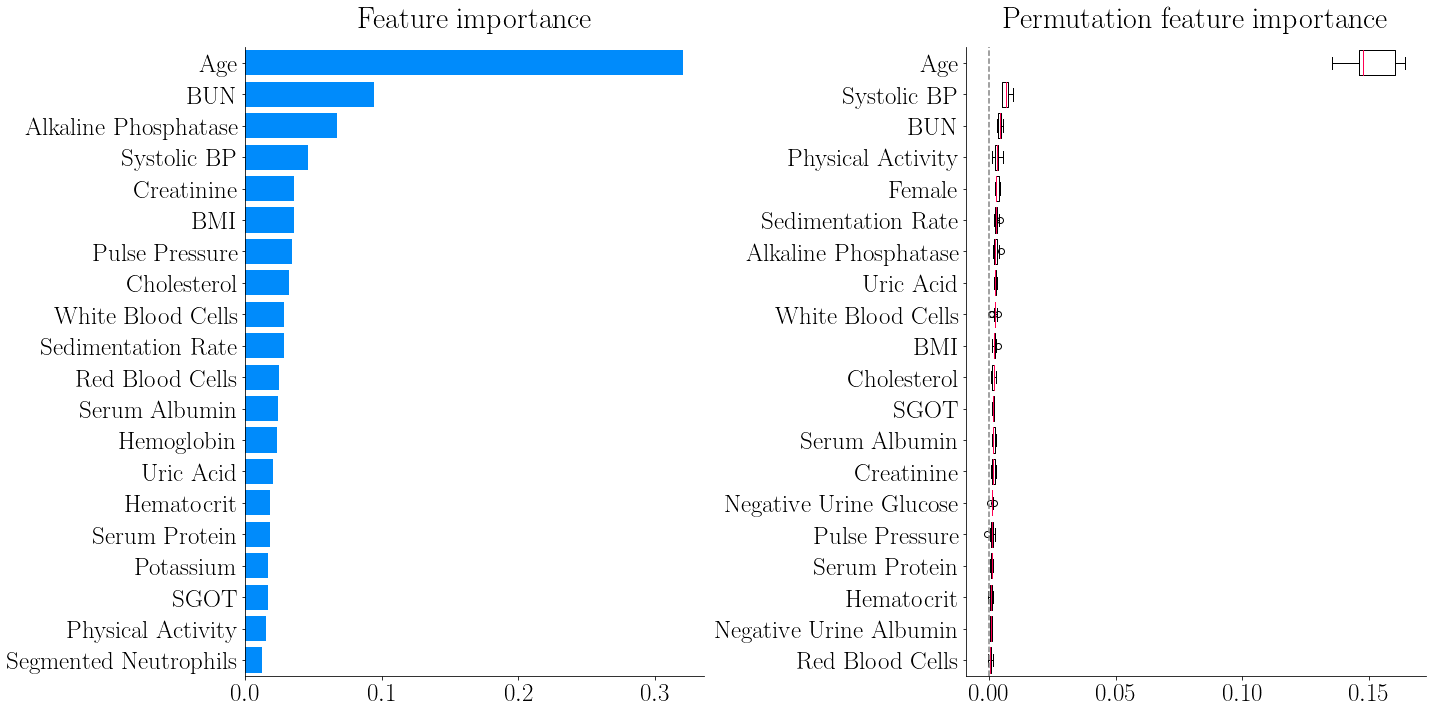

In [16]:
fig, (ax1, ax2)= plt.subplots(1,2, figsize = (20,10))
sns.barplot(x = rf_fi[np.argsort(-rf_fi)][:20],  y = np.array(col_labels)[np.argsort(-rf_fi)][:20], ax = ax1, color=shap_blue, saturation=1)
ax1.tick_params(axis = 'both', labelsize = 25)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_title('Feature importance', fontsize = 30, pad = 20)
ax2.boxplot(x = rf_log_loss_imp[rf_log_loss_sort[-20:],:].T, vert=False, widths = 0.8, labels=np.array(col_labels)[rf_log_loss_sort][-20:],
            medianprops = {'color': shap_red})
ax2.axvline(0, ls = '--', color = shap_gray)
ax2.tick_params(axis = 'both', labelsize = 25)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.set_title('Permutation feature importance', fontsize = 30, pad = 20)
fig.tight_layout()
plt.show()

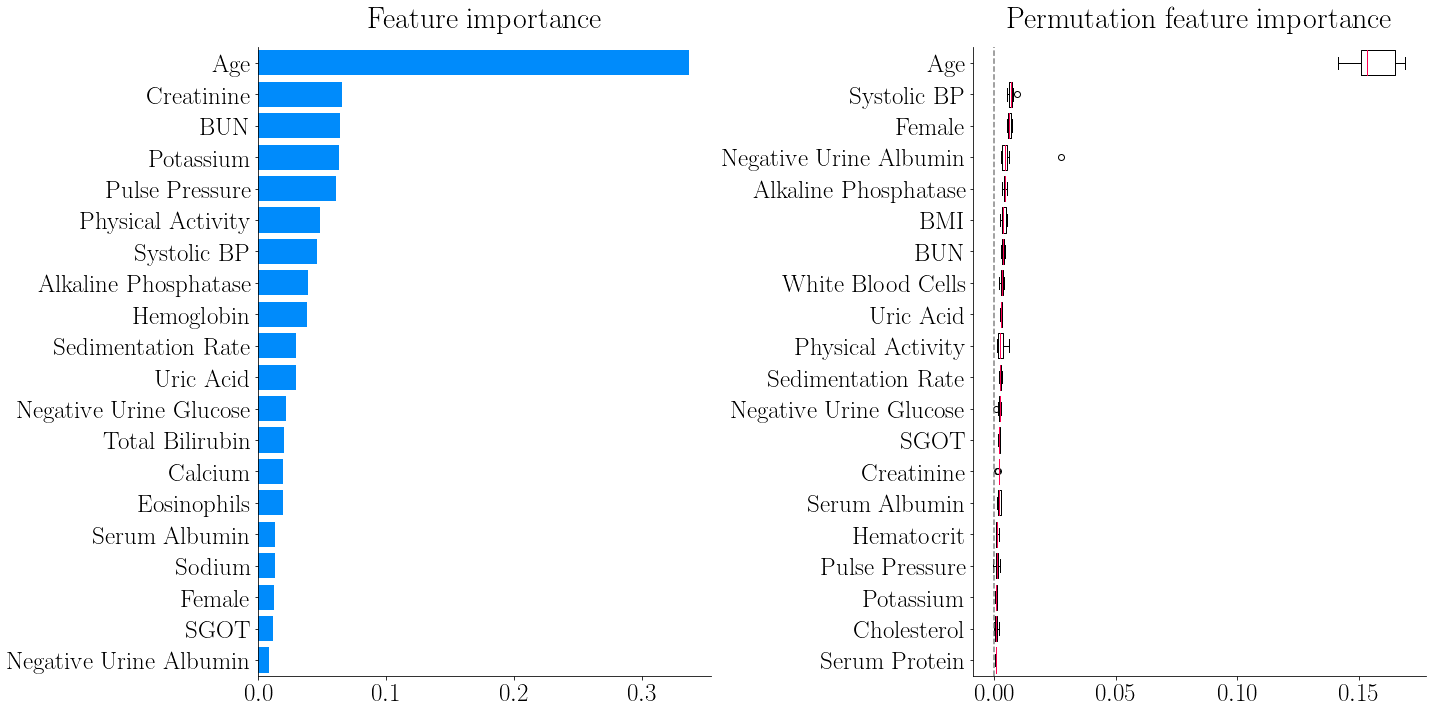

In [17]:
fig, (ax1, ax2)= plt.subplots(1,2, figsize = (20,10))
sns.barplot(x = rpf_fi[np.argsort(-rpf_fi)][:20],  y = np.array(col_labels)[np.argsort(-rpf_fi)][:20], ax = ax1, color=shap_blue, saturation=1)
ax1.tick_params(axis = 'both', labelsize = 25)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_title('Feature importance', fontsize = 30, pad = 20)
ax2.boxplot(x = rpf_log_loss_imp[rpf_log_loss_sort[-20:],:].T,vert=False, widths = 0.8, labels=np.array(col_labels)[rpf_log_loss_sort][-20:],
            medianprops = {'color': shap_red})
ax2.axvline(0, ls = '--', color = shap_gray)
ax2.tick_params(axis = 'both', labelsize = 25)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.set_title('Permutation feature importance', fontsize = 30, pad = 20)
fig.tight_layout()
plt.show()

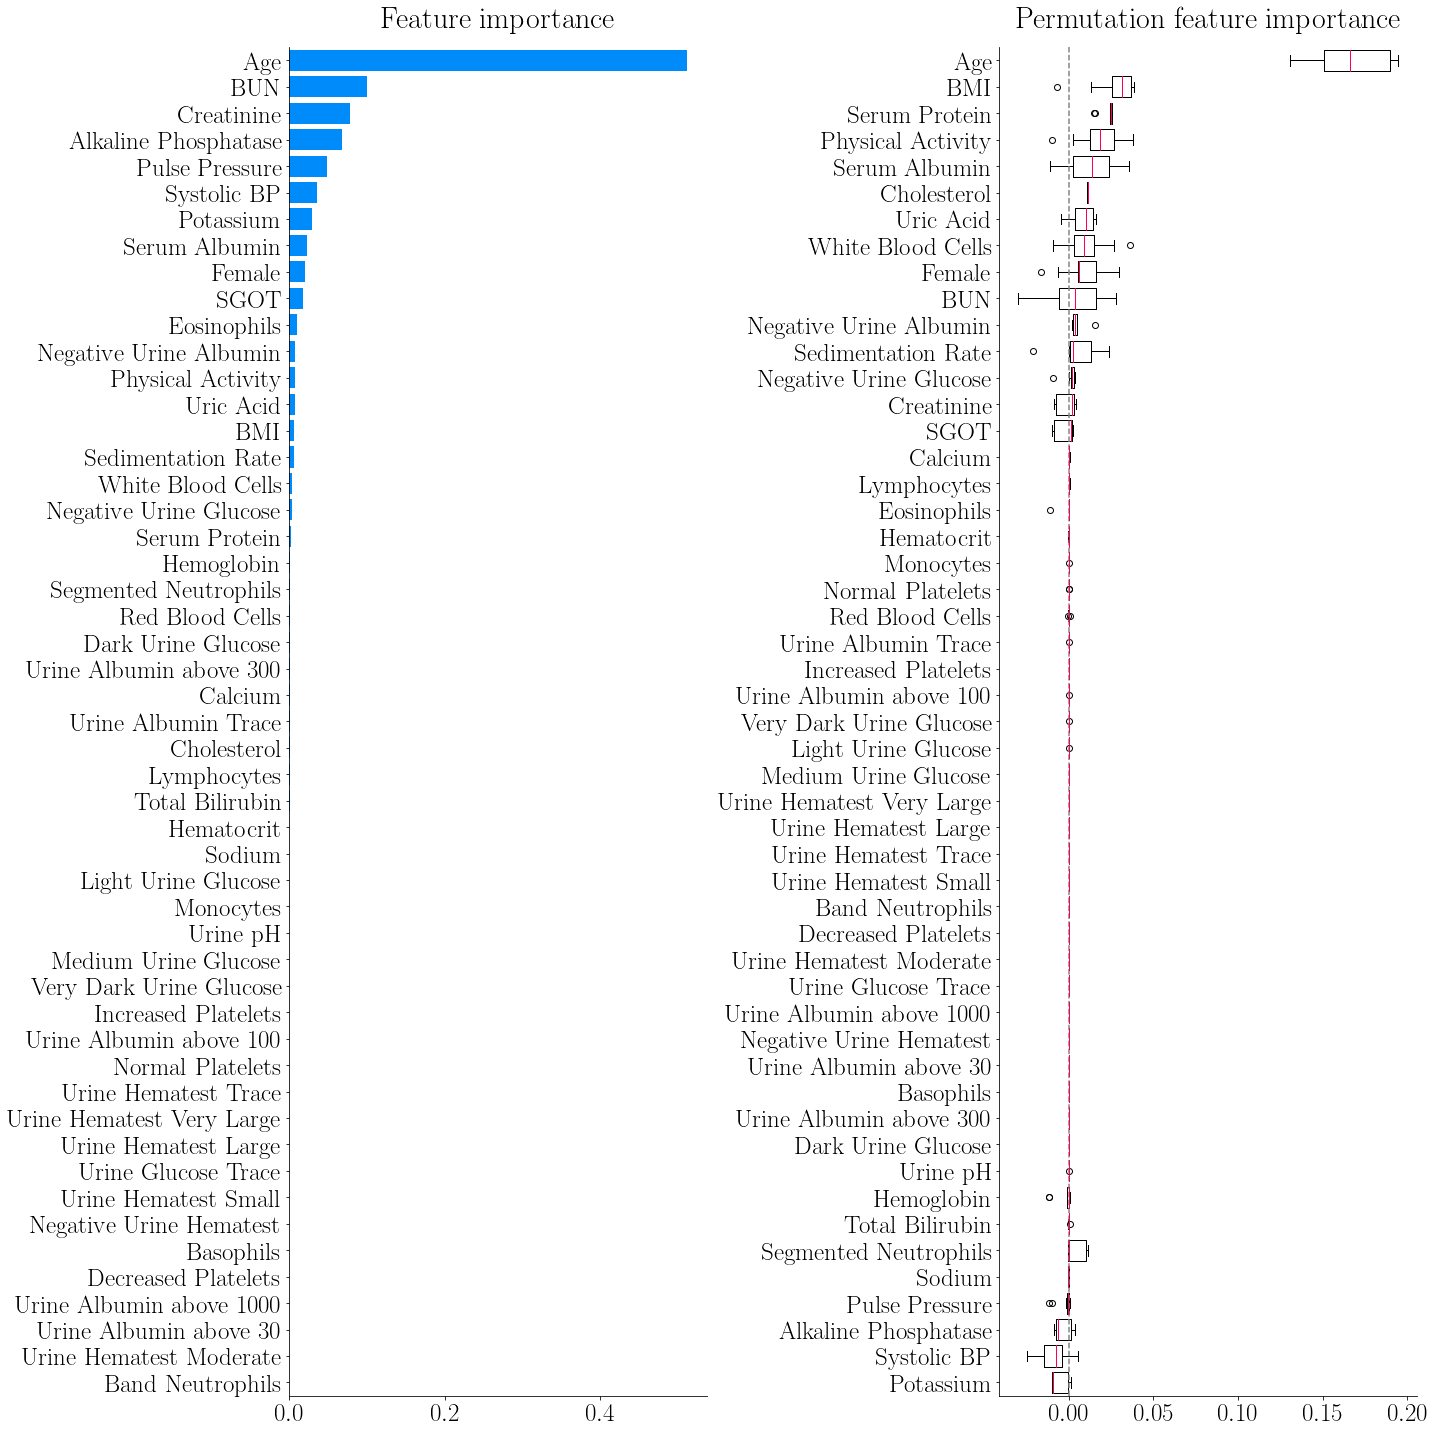

In [18]:
fig, (ax1, ax2)= plt.subplots(1,2, figsize = (20,20))
sns.barplot(x = base_fi[np.argsort(-base_fi)],  y = np.array(col_labels)[np.argsort(-base_fi)], ax = ax1, color=shap_blue, saturation=1)
ax1.tick_params(axis = 'both', labelsize = 25)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_title('Feature importance', fontsize = 30, pad = 20)
ax2.boxplot(x = base_log_loss_imp[base_log_loss_sort,:].T,vert=False, widths = 0.8, labels=np.array(col_labels)[base_log_loss_sort],
            medianprops = {'color': shap_red})
ax2.axvline(0, ls = '--', color = shap_gray)
ax2.tick_params(axis = 'both', labelsize = 25)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.set_title('Permutation feature importance', fontsize = 30, pad = 20)
fig.tight_layout()
plt.show()

## FEATURE DEPENDENCE

In [19]:
dep_obs = np.load('Results/SHAP_rand_rows.npy')
rf_shap = joblib.load('Results/RF_SHAP.pkl')
rf_shap_values = joblib.load('Results/RF_SHAP_values.pkl')
rf_shap_interaction_values = joblib.load('Results/RF_SHAP_interaction_values.pkl')

In [20]:
X_dep = X_train_trans[dep_obs,:]
y_dep = y_train[dep_obs]

In [21]:
train_rpf_pred_int = joblib.load('Results/train_pur_proba_L2_int.pkl')
rpf_int = train_rpf_pred_int.iloc[dep_obs, :]

In [22]:
rpf_compoenet_size = np.array([len(re.findall('[0-9][0-9].0|[0-9].0', x)) for x in rpf_int.columns])
pd.DataFrame(np.unique(rpf_compoenet_size, return_counts=True))

,0,1,2,3,4,5,6,7
0,0,1,2,3,4,5,6,7
1,2,40,409,886,460,106,14,1


In [23]:
rpf_int_only = rpf_int.drop(['Intercept','Pred'], axis = 1).copy()
rpf_int_lookup = pd.DataFrame([], columns = ['Features', 'Interaction', 'Index'])
for c in range(len(rpf_int_only.columns)):
    features = [int(float(x)) for x in re.findall('[0-9][0-9].0|[0-9].0', rpf_int_only.columns[c])]
    num_features = len(features) 
    temp_df = pd.DataFrame({'Features': features, 'Interaction':np.repeat(num_features, num_features), 
                            'Index': np.repeat(c, num_features)})
    rpf_int_lookup = pd.concat([rpf_int_lookup, temp_df], axis = 0)

In [24]:
rpf_summary = pd.DataFrame([])
for i in range(len(X_train.columns)):
    weights = 1/rpf_int_lookup.Interaction[rpf_int_lookup.Features == i].to_numpy(dtype = float)
    weights = weights.reshape(-1,1)
    cols = rpf_int_lookup.Index[rpf_int_lookup.Features == i].to_numpy(dtype = int)
    effects = np.matmul(rpf_int_only.iloc[:, cols].to_numpy(), weights.reshape(-1,1)).T[0]
    rpf_summary[col_labels[i]] = effects

In [43]:
rpf_main_effect = rpf_int.iloc[:,np.array([len(re.findall('[1-9][0-9].0|[0-9].0', x)) == 1 for x in rpf_int.columns])]
feat_ind = np.array([int(float(re.findall('[1-9][0-9].0|[0-9].0', x)[0])) for x in rpf_main_effect.columns])
sorted_feat_ind = np.sort(feat_ind)
rpf_main_effect = rpf_main_effect.set_axis(np.array(col_labels)[feat_ind], axis = 1)
rpf_main_effect = rpf_main_effect[np.array(col_labels)[sorted_feat_ind]]

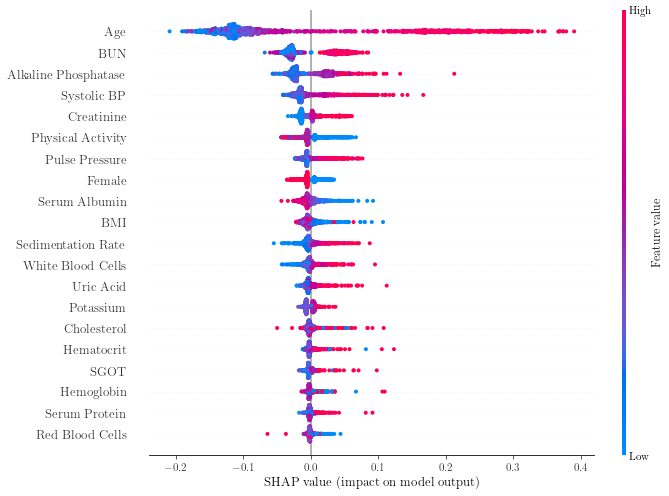

In [42]:
shap.summary_plot(rf_shap_values[1], feature_names=col_labels, features=X_dep, show = False)
fig, ax = plt.gcf(), plt.gca()
fig.set_size_inches(10,7)
fig.tight_layout()
plt.show()

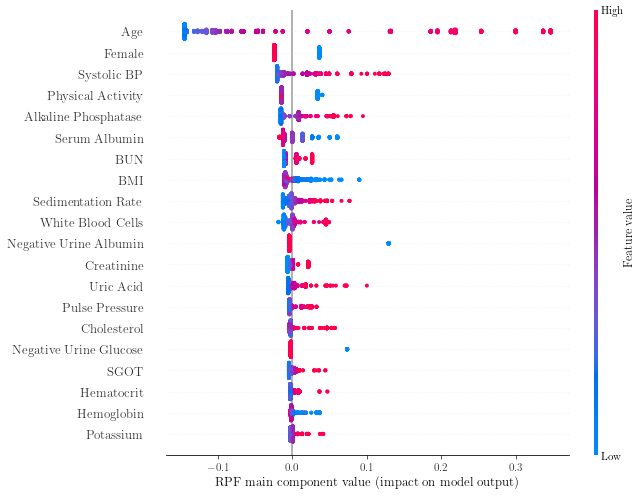

In [45]:
shap.summary_plot(rpf_main_effect.to_numpy(), feature_names=rpf_main_effect.columns, features=X_dep[:,np.sort(feat_ind)], show = False)
fig, ax = plt.gcf(), plt.gca()
fig.set_size_inches(9.5,7)
ax.set_xlabel('RPF main component value (impact on model output)')
fig.tight_layout()
plt.show()

In [47]:
abs_means_rpf = rpf_int_only.abs().mean(0).to_numpy()
rpf_means_sort = abs_means_rpf.argsort()
rpf_int_names = add_feature_names(rpf_int_only, col_labels).columns

In [48]:
rpf_top_20_components = np.array([re.sub("__"," and ",x) for x in rpf_int_names[rpf_means_sort[-20:]]])

In [49]:
rpf_2order_effect = rpf_int.iloc[:,np.array([len(re.findall('[1-9][0-9].0|[0-9].0', x)) == 2 for x in rpf_int.columns])]
rpf_2order_effect = add_feature_names(rpf_2order_effect, col_labels)

In [50]:
rpf_2order_effect_means = rpf_2order_effect.abs().mean(0).to_numpy()
rpf_2order_means_sort = rpf_2order_effect_means.argsort()
rpf_2order_names = rpf_2order_effect.columns
rpf_top_20_2order_components = np.array([re.sub("__"," and ",x) for x in rpf_2order_names[rpf_2order_means_sort[-20:]]])

In [51]:
int_mean_abs_effects_rf = pd.DataFrame([], columns=['Features', 'Effect'])
for i in range(51):
    for j in range((i+1), 51):
        feature_names = col_labels[i] + ' and ' + col_labels[j] 
        int_mean_effect = np.mean(abs(rf_shap_interaction_values[1][:,i, j]))
        temp_df = pd.DataFrame({'Features': feature_names, 'Effect': int_mean_effect}, index=[0])
        int_mean_abs_effects_rf = pd.concat([int_mean_abs_effects_rf, temp_df], axis = 0)
int_mean_abs_effects_rf = int_mean_abs_effects_rf.sort_values(by = 'Effect', ascending=False)

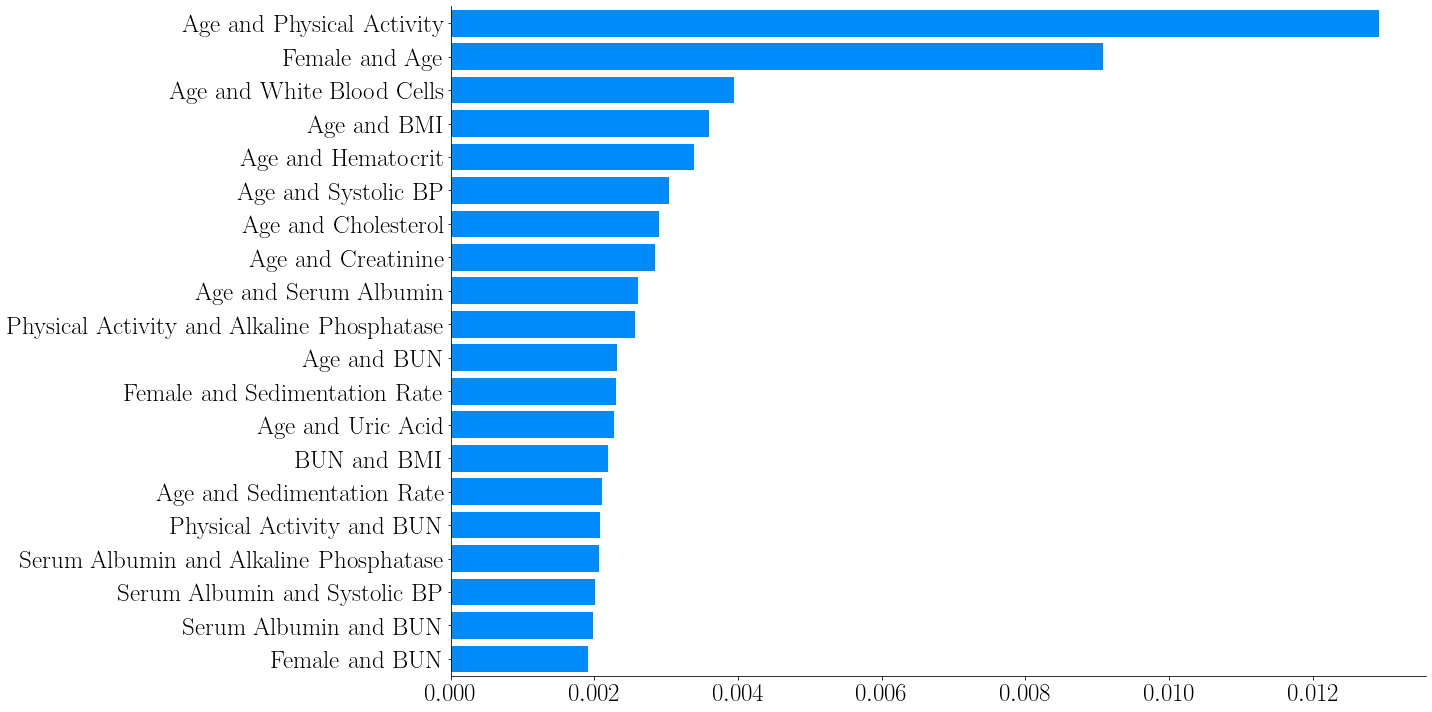

In [53]:
fig, ax=plt.subplots(1,1,figsize = (20,10))
sns.barplot(x = rpf_2order_effect_means[rpf_2order_means_sort[-20:]][::-1], 
                  y = rpf_top_20_2order_components[::-1], color=shap_blue, saturation = 1, ax = ax)
ax.tick_params(axis = 'both', labelsize = 25)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.tight_layout()
plt.show()

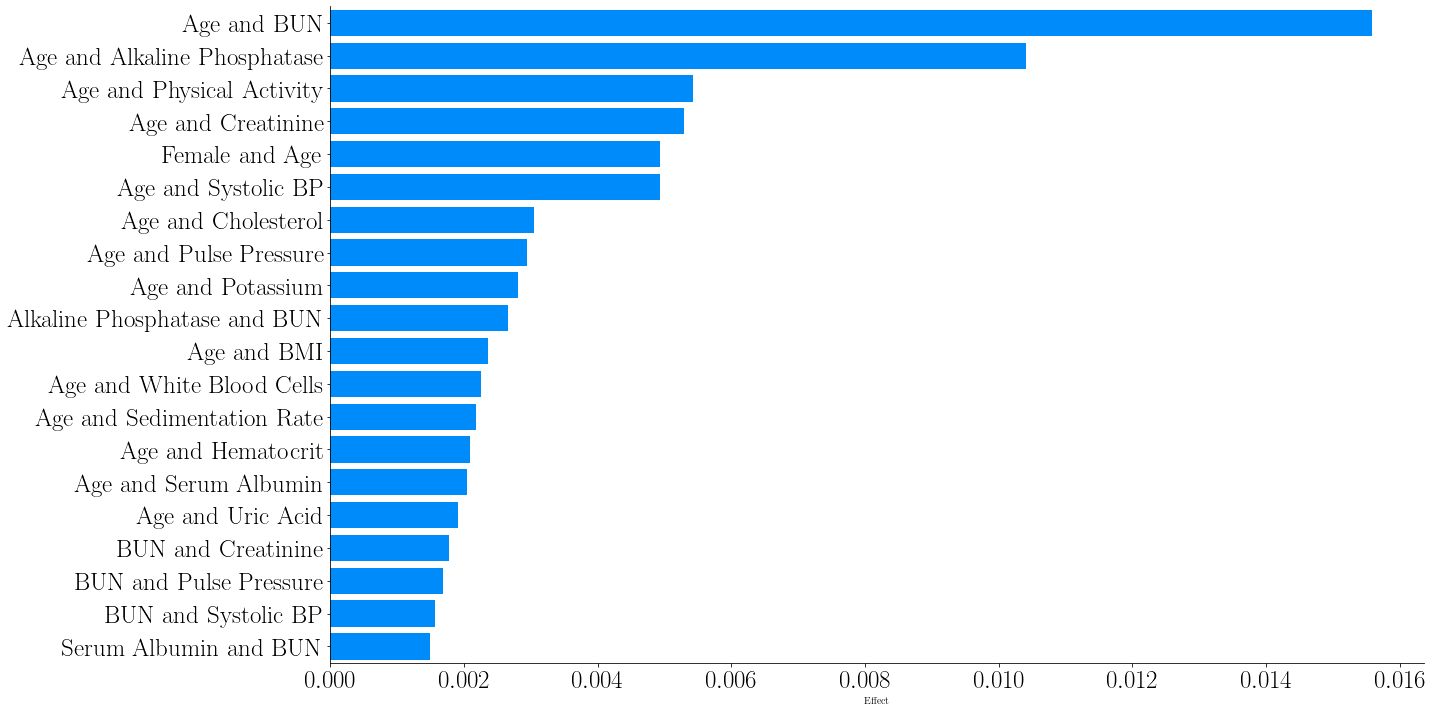

In [54]:
fig, ax=plt.subplots(1,1,figsize = (20,10))
sns.barplot(x = int_mean_abs_effects_rf.Effect[:20], 
                  y = int_mean_abs_effects_rf.Features[:20], color=shap_blue, saturation=1,ax = ax)
ax.tick_params(axis = 'both', labelsize = 25)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel("")
fig.tight_layout()
plt.show()

In [84]:
train_rpf_pred_base = joblib.load('Results/train_pur_proba_L2_base.pkl')
rpf_base = train_rpf_pred_base.iloc[dep_obs, :]

In [85]:
rpf_base_only = rpf_base.drop(['Intercept','Pred'], axis = 1).copy()
rpf_base_summary = add_feature_names(rpf_base_only, col_labels)

In [86]:
in_cols = np.array([x in rpf_base_summary.columns for x in col_labels])
rpf_base_summary = rpf_base_summary[np.array(col_labels)[in_cols]]

In [87]:
in_cols_ind = np.array([np.argwhere(X_train.columns == X_train.columns[in_cols][x])[0][0] for x in range(len(X_train.columns[in_cols]))])

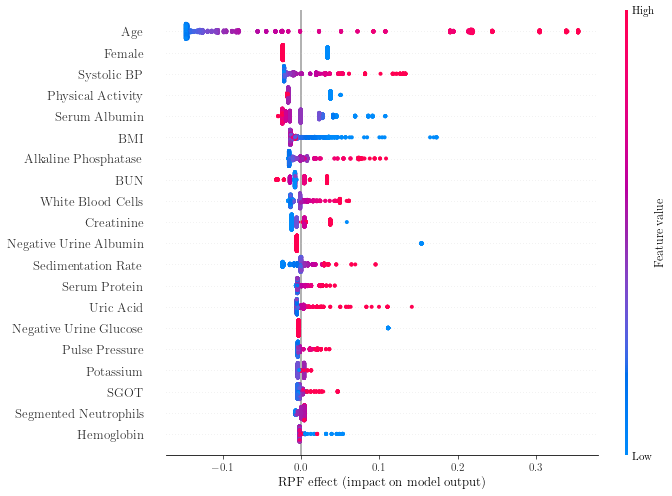

In [88]:
shap.summary_plot(rpf_base_summary.to_numpy(), feature_names = np.array(col_labels)[in_cols],features=X_dep[:,in_cols_ind], show = False)
fig, ax = plt.gcf(), plt.gca()
fig.set_size_inches(10,7)
ax.set_xlabel('RPF effect (impact on model output)')
fig.tight_layout()
plt.show()

In [299]:
bun_ind = np.argwhere(X_train.columns =='BUN')[0][0] #hard cut
sbp_ind = np.argwhere(X_train.columns =='systolic_blood_pressure')[0][0] #smooth
age_ind = np.argwhere(X_train.columns =='age')[0][0] #smooth
sex_ind = np.argwhere(X_train.columns == 'sex_isFemale')[0][0]
act_ind = np.argwhere(X_train.columns == 'physical_activity')[0][0]
pp_ind = np.argwhere(X_train.columns == 'pulse_pressure')[0][0]
bmi_ind = np.argwhere(X_train.columns == 'BMI')[0][0]
salb_ind = np.argwhere(X_train.columns == 'serum_albumin')[0][0]
alkpho_ind = np.argwhere(X_train.columns == 'alkaline_phosphatase')[0][0]
wbc_ind = np.argwhere(X_train.columns == 'white_blood_cells')[0][0]

### AGE effects

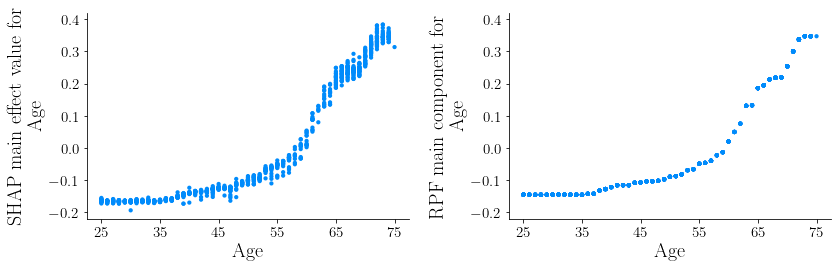

In [175]:
fig, ax = plt.subplots(1,2, figsize = (12,4))
ax1 = sns.scatterplot(x = X_dep[:,age_ind], y = rf_shap_interaction_values[1][:,age_ind, age_ind], color = shap_blue, 
                      edgecolor = 'none', size = 5, legend=False, ax = ax[0])
ax1.set_ylim(-0.22, 0.42)
ax1.set_yticks([-0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4])
ax1.set_xticks([25,35,45,55,65,75])
ax1.tick_params(labelsize = 15)
ax1.set_xlabel('Age', fontsize = 20)
ax1.set_ylabel('SHAP main effect value for \n Age', fontsize = 20)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax2 = sns.scatterplot(x = X_dep[:,age_ind], y = rpf_main_effect['Age'], color = shap_blue, 
                      edgecolor = 'none', size = 5, legend=False, ax = ax[1])
ax2.set_ylim(-0.22, 0.42)
ax2.set_yticks([-0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4])
ax2.set_xticks([25,35,45,55,65,75])
ax2.tick_params(labelsize = 15)
ax2.set_xlabel('Age', fontsize = 20)
ax2.set_ylabel('RPF main component for \n Age', fontsize = 20)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
fig.tight_layout(pad = 2)
plt.show()


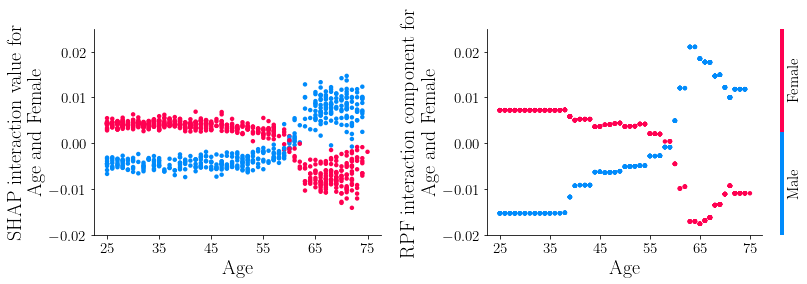

In [177]:
fig, ax = plt.subplots(1,2, figsize = (12,4), gridspec_kw={'width_ratios': [1, 1.2]})
ax1 = ax[0].scatter(X_dep[:,age_ind], rf_shap_interaction_values[1][:,age_ind, sex_ind], c = X_dep[:,sex_ind], 
                      cmap = shap_discrete_cmap, edgecolor = 'none', s = 20)
ax[0].set_xticks([25,35,45,55,65,75])
ax[0].set_ylim(-0.02, 0.025)
ax[0].set_yticks([-0.02, -0.01, 0, 0.01, 0.02])
ax[0].tick_params(labelsize = 15)
ax[0].set_xlabel('Age', fontsize = 20)
ax[0].set_ylabel('SHAP interaction value for \n Age and Female', fontsize = 20)
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax2 = ax[1].scatter(X_dep[:,age_ind], rpf_2order_effect['Female__Age'], c = X_dep[:,sex_ind], 
                      cmap = shap_discrete_cmap, edgecolor = 'none', s = 20)
ax[1].set_xticks([25,35,45,55,65,75])
ax[1].set_ylim(-0.02, 0.025)
ax[1].set_yticks([-0.02, -0.01, 0, 0.01, 0.02])
ax[1].tick_params(labelsize = 15)
ax[1].set_xlabel('Age', fontsize = 20)
ax[1].set_ylabel('RPF interaction component for \n Age and Female', fontsize = 20)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
cbar = plt.colorbar(ax2, ax = ax[1], aspect = 50)
cbar.ax.tick_params(labelsize=15, size = 0)
cbar.set_ticks([0.25, 0.75])
cbar.ax.set_yticklabels(['Male', 'Female'], rotation = 'vertical', va = 'center')
cbar.outline.set_visible(False)
fig.tight_layout(pad = 2)
plt.show()

### SYSTOLIC BP effect

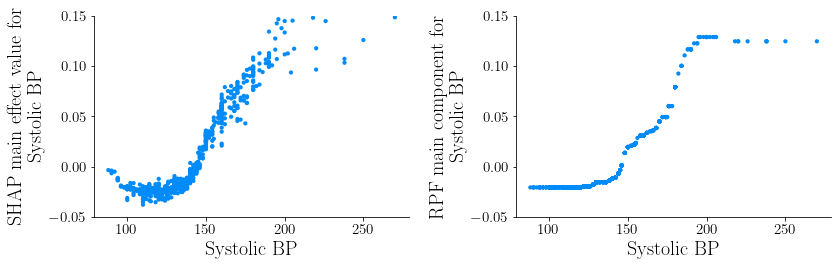

In [193]:
fig, ax = plt.subplots(1,2, figsize = (12,4))
ax1 = sns.scatterplot(x = X_dep[:,sbp_ind], y = rf_shap_interaction_values[1][:,sbp_ind, sbp_ind], color = shap_blue, 
                      edgecolor = 'none', size = 5, legend=False, ax = ax[0])
ax1.set_ylim(-0.05, 0.15)
ax1.set_yticks([-0.05, 0, 0.05, 0.1, 0.15])
ax1.set_xticks([100,150,200,250])
ax1.tick_params(labelsize = 15)
ax1.set_xlabel('Systolic BP', fontsize = 20)
ax1.set_ylabel('SHAP main effect value for \n Systolic BP', fontsize = 20)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax2 = sns.scatterplot(x = X_dep[:,sbp_ind], y = rpf_main_effect['Systolic BP'], color = shap_blue, 
                      edgecolor = 'none', size = 5, legend=False, ax = ax[1])
ax2.set_ylim(-0.05, 0.15)
ax2.set_yticks([-0.05, 0, 0.05, 0.1, 0.15])
ax2.set_xticks([100,150,200,250])
ax2.tick_params(labelsize = 15)
ax2.set_xlabel('Systolic BP', fontsize = 20)
ax2.set_ylabel('RPF main component for \n Systolic BP', fontsize = 20)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
fig.tight_layout(pad = 2)
plt.show()


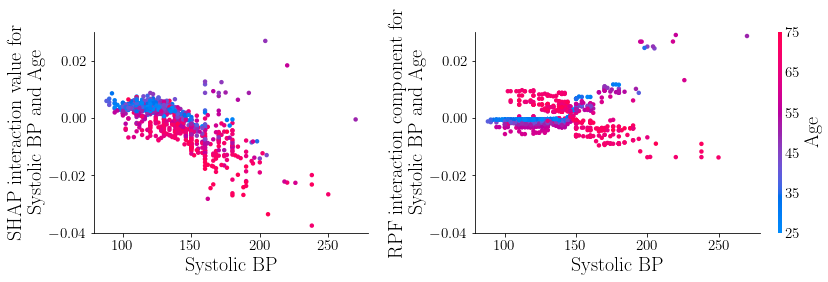

In [207]:
fig, ax = plt.subplots(1,2, figsize = (12,4), gridspec_kw={'width_ratios': [1, 1.3]})
ax1 = ax[0].scatter(X_dep[:,sbp_ind], rf_shap_interaction_values[1][:,sbp_ind, age_ind], c = X_dep[:,age_ind], 
                      cmap = shap_cmap, edgecolor = 'none', s = 20)
ax[0].set_xticks([100,150,200,250])
ax[0].set_ylim(-0.04, 0.03)
ax[0].set_yticks([-0.04, -0.02, 0, 0.02])
ax[0].tick_params(labelsize = 15)
ax[0].set_xlabel('Systolic BP', fontsize = 20)
ax[0].set_ylabel('SHAP interaction value for \n Systolic BP and Age', fontsize = 20)
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax2 = ax[1].scatter(X_dep[:,sbp_ind], rpf_2order_effect['Age__Systolic BP'], c = X_dep[:,age_ind], 
                      cmap = shap_cmap, edgecolor = 'none', s = 20)
ax[1].set_xticks([100,150,200,250])
ax[1].set_ylim(-0.04, 0.03)
ax[1].set_yticks([-0.04, -0.02, 0, 0.02])
ax[1].tick_params(labelsize = 15)
ax[1].set_xlabel('Systolic BP', fontsize = 20)
ax[1].set_ylabel('RPF interaction component for \n Systolic BP and Age', fontsize = 20)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
cbar = plt.colorbar(ax2, ax = ax[1], aspect = 50)
cbar.ax.tick_params(labelsize=15, size = 0)
cbar.set_ticks([25,35,45,55,65,75])
cbar.set_label('Age', fontsize = 20)
cbar.outline.set_visible(False)
fig.tight_layout(pad = 2)
plt.show()

## BMI

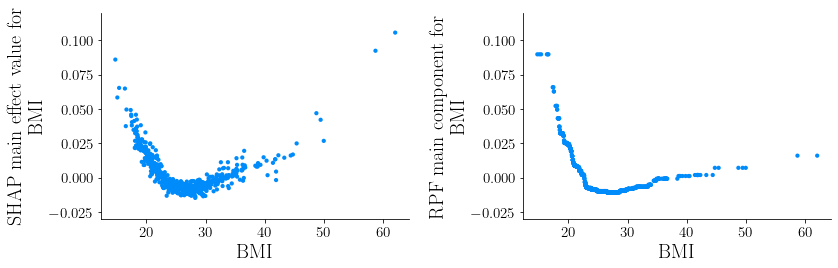

In [810]:
fig, ax = plt.subplots(1,2, figsize = (12,4))
ax1 = sns.scatterplot(x = X_dep[:,bmi_ind], y = rf_shap_interaction_values[1][:,bmi_ind, bmi_ind], color = shap_blue, 
                      edgecolor = 'none', size = 5, legend=False, ax = ax[0])
ax1.set_ylim(-0.03, 0.12)
ax1.set_yticks([-0.025, 0, 0.025, 0.05, 0.075, 0.1])
ax1.set_xticks([20,30,40,50,60])
ax1.tick_params(labelsize = 15)
ax1.set_xlabel('BMI', fontsize = 20)
ax1.set_ylabel('SHAP main effect value for \n BMI', fontsize = 20)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax2 = sns.scatterplot(x = X_dep[:,bmi_ind], y = rpf_main_effect['BMI'], color = shap_blue, 
                      edgecolor = 'none', size = 5, legend=False, ax = ax[1])
ax2.set_ylim(-0.03, 0.12)
ax2.set_yticks([-0.025, 0, 0.025, 0.05, 0.075, 0.1])
ax2.set_xticks([20,30,40,50,60])
ax2.tick_params(labelsize = 15)
ax2.set_xlabel('BMI', fontsize = 20)
ax2.set_ylabel('RPF main component for \n BMI', fontsize = 20)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
fig.tight_layout(pad = 2)
plt.show()


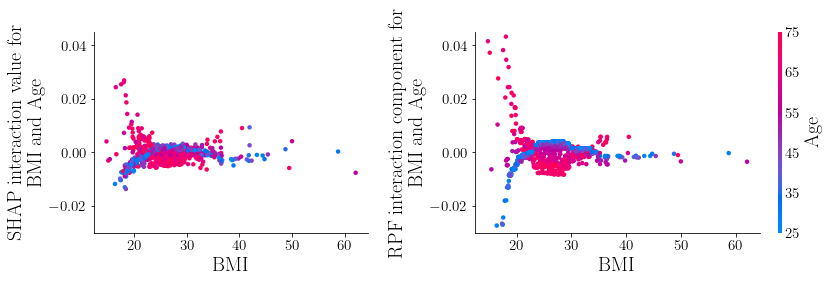

In [812]:
fig, ax = plt.subplots(1,2, figsize = (12,4), gridspec_kw={'width_ratios': [1, 1.3]})
ax1 = ax[0].scatter(X_dep[:,bmi_ind], rf_shap_interaction_values[1][:,bmi_ind, age_ind], c = X_dep[:,age_ind], 
                      cmap = shap_cmap, edgecolor = 'none', s = 20)
ax[0].set_xticks([20,30,40,50,60])
ax[0].set_ylim(-0.03, 0.045)
ax[0].set_yticks([-0.02, 0, 0.02, 0.04])
ax[0].tick_params(labelsize = 15)
ax[0].set_xlabel('BMI', fontsize = 20)
ax[0].set_ylabel('SHAP interaction value for \n BMI and Age', fontsize = 20)
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax2 = ax[1].scatter(X_dep[:,bmi_ind], rpf_2order_effect['Age__BMI'], c = X_dep[:,age_ind], 
                      cmap = shap_cmap, edgecolor = 'none', s = 20)
ax[1].set_xticks([20,30,40,50,60])
ax[1].set_ylim(-0.03, 0.045)
ax[1].set_yticks([-0.02, 0, 0.02, 0.04])
ax[1].tick_params(labelsize = 15)
ax[1].set_xlabel('BMI', fontsize = 20)
ax[1].set_ylabel('RPF interaction component for \n BMI and Age', fontsize = 20)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
cbar = plt.colorbar(ax2, ax = ax[1], aspect = 50)
cbar.ax.tick_params(labelsize=15, size = 0)
cbar.set_ticks([25,35,45,55,65,75])
cbar.set_label('Age', fontsize = 20)
cbar.outline.set_visible(False)
fig.tight_layout(pad = 2)
plt.show()

## Alkaline Phosphatase

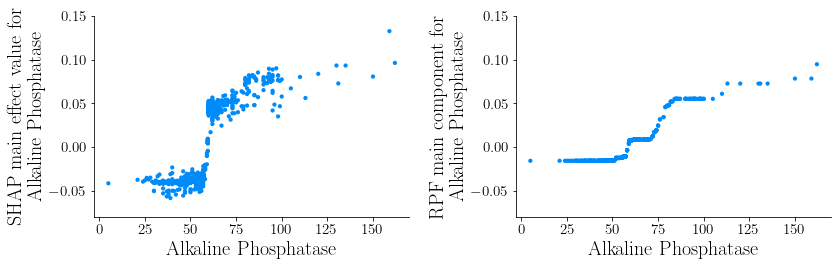

In [224]:
fig, ax = plt.subplots(1,2, figsize = (12,4))
ax1 = sns.scatterplot(x = X_dep[:,alkpho_ind], y = rf_shap_interaction_values[1][:,alkpho_ind, alkpho_ind], color = shap_blue, 
                      edgecolor = 'none', size = 5, legend=False, ax = ax[0])
ax1.set_ylim(-0.08, 0.15)
ax1.set_yticks([-0.05, 0, 0.05, 0.1, 0.15])
ax1.set_xticks([0, 25, 50,75, 100, 125, 150])
ax1.tick_params(labelsize = 15)
ax1.set_xlabel('Alkaline Phosphatase', fontsize = 20)
ax1.set_ylabel('SHAP main effect value for \n Alkaline Phosphatase', fontsize = 20)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax2 = sns.scatterplot(x = X_dep[:,alkpho_ind], y = rpf_main_effect['Alkaline Phosphatase'], color = shap_blue, 
                      edgecolor = 'none', size = 5, legend=False, ax = ax[1])
ax2.set_ylim(-0.08, 0.15)
ax2.set_yticks([-0.05, 0, 0.05, 0.1, 0.15])
ax2.set_xticks([0, 25, 50,75, 100, 125, 150])
ax2.tick_params(labelsize = 15)
ax2.set_xlabel('Alkaline Phosphatase', fontsize = 20)
ax2.set_ylabel('RPF main component for \n Alkaline Phosphatase', fontsize = 20)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
fig.tight_layout(pad = 2)
plt.show()


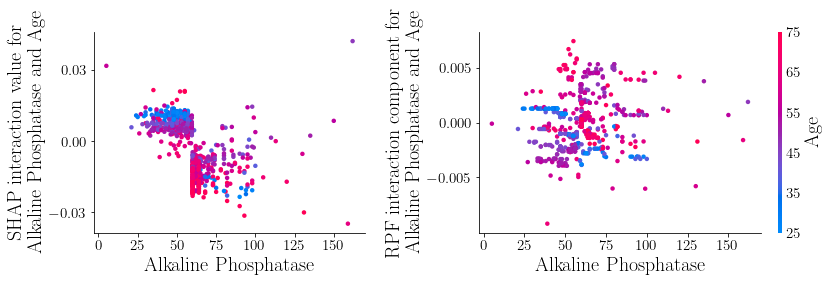

In [282]:
fig, ax = plt.subplots(1,2, figsize = (12,4), gridspec_kw={'width_ratios': [1, 1.3]})
ax1 = ax[0].scatter(X_dep[:,alkpho_ind], rf_shap_interaction_values[1][:,alkpho_ind, age_ind], c = X_dep[:,age_ind], 
                      cmap = shap_cmap, edgecolor = 'none', s = 20)
ax[0].set_xticks([0, 25, 50,75, 100, 125, 150])
#ax[0].set_ylim(-0.04, 0.045)
ax[0].set_yticks([-0.03, 0, 0.03])
ax[0].tick_params(labelsize = 15)
ax[0].set_xlabel('Alkaline Phosphatase', fontsize = 20)
ax[0].set_ylabel('SHAP interaction value for \n Alkaline Phosphatase and Age', fontsize = 20)
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax2 = ax[1].scatter(X_dep[:,alkpho_ind], rpf_2order_effect['Age__Alkaline Phosphatase'], c = X_dep[:,age_ind], 
                      cmap = shap_cmap, edgecolor = 'none', s = 20)
ax[1].set_xticks([0, 25, 50,75, 100, 125, 150])
#ax[1].set_ylim(-0.04, 0.045)
ax[1].set_yticks([-0.005, 0, 0.005])
ax[1].tick_params(labelsize = 15)
ax[1].set_xlabel('Alkaline Phosphatase', fontsize = 20)
ax[1].set_ylabel('RPF interaction component for \n Alkaline Phosphatase and Age', fontsize = 20)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
cbar = plt.colorbar(ax2, ax = ax[1], aspect = 50)
cbar.ax.tick_params(labelsize=15, size = 0)
cbar.set_ticks([25,35,45,55,65,75])
cbar.set_label('Age', fontsize = 20)
cbar.outline.set_visible(False)
fig.tight_layout(pad = 2)
plt.show()

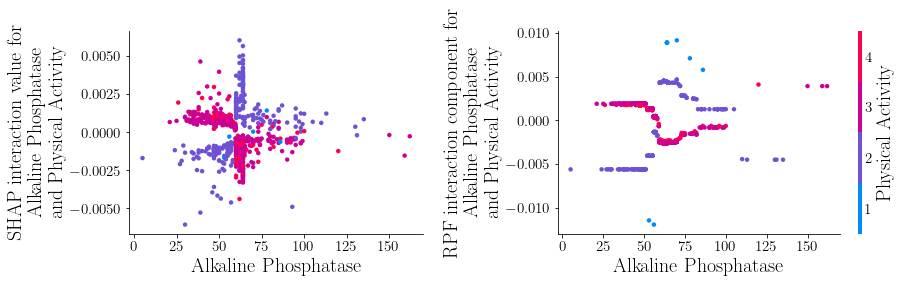

In [342]:
fig, ax = plt.subplots(1,2, figsize = (13,4), gridspec_kw={'width_ratios': [1, 1.2]})
ax1 = ax[0].scatter(X_dep[:,alkpho_ind], rf_shap_interaction_values[1][:,alkpho_ind, act_ind], c = X_dep[:,act_ind], 
                      cmap = shap_multi_discrete_map, edgecolor = 'none', s = 20)
ax[0].set_xticks([0, 25, 50,75, 100, 125, 150])
#ax[0].set_ylim(-0.015, 0.01)
#ax[0].set_yticks([-0.02, 0, 0.02, 0.04])
ax[0].tick_params(labelsize = 15)
ax[0].set_xlabel('Alkaline Phosphatase', fontsize = 20)
ax[0].set_ylabel('SHAP interaction value for \n Alkaline Phosphatase \n and Physical Activity', fontsize = 20)
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax2 = ax[1].scatter(X_dep[:,alkpho_ind], rpf_2order_effect['Physical Activity__Alkaline Phosphatase'], c = X_dep[:,act_ind], 
                      cmap = shap_multi_discrete_map, edgecolor = 'none', s = 20)
ax[1].set_xticks([0, 25, 50,75, 100, 125, 150])
#ax[1].set_ylim(-0.03, 0.04)
#ax[1].set_yticks([-0.02, 0, 0.02, 0.04])
ax[1].tick_params(labelsize = 15)
ax[1].set_xlabel('Alkaline Phosphatase', fontsize = 20)
ax[1].set_ylabel('RPF interaction component for \n Alkaline Phosphatase \n and Physical Activity', fontsize = 20)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
cbar = plt.colorbar(ax2, ax = ax[1], aspect = 50)
cbar.ax.tick_params(labelsize=15, size = 0)
cbar.set_ticks([1.375,2.125,2.875, 3.625])
cbar.ax.set_yticklabels([1,2,3,4])
cbar.set_label('Physical Activity', fontsize = 20)
cbar.outline.set_visible(False)
fig.tight_layout(pad = 2)
plt.show()

In [292]:
imputer.vals_imp[['age', 'sex','alkaline_phosphatase']].pivot(index = 'sex', columns = 'age', values = 'alkaline_phosphatase')

age,0,1,2,3,4
sex,,,,,
0,55.0,57.0,59.5,62.0,60.0
1,48.0,47.0,56.0,62.0,64.0


## BUN

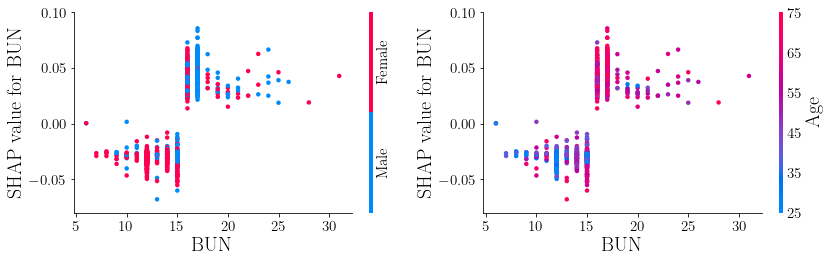

In [278]:
fig, ax = plt.subplots(1,2, figsize = (12,4), gridspec_kw={'width_ratios': [1, 1]})
ax1 = ax[1].scatter(X_dep[:,bun_ind], rf_shap_values[1][:,bun_ind], c = X_dep[:,age_ind], 
                      cmap = shap_cmap, edgecolor = 'none', s = 20)
ax[1].set_xticks([5, 10, 15, 20, 25, 30])
ax[1].set_ylim(-0.08, 0.1)
ax[1].set_yticks([-0.05, 0, 0.05, 0.1])
ax[1].tick_params(labelsize = 15)
ax[1].set_xlabel('BUN', fontsize = 20)
ax[1].set_ylabel('SHAP value for BUN', fontsize = 20)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
cbar1 = plt.colorbar(ax1, ax = ax[1], aspect = 50)
cbar1.ax.tick_params(labelsize=15, size = 0)
cbar1.set_ticks([25,35,45,55,65,75])
cbar1.set_label('Age', fontsize = 20)
cbar1.outline.set_visible(False)
ax2 = ax[0].scatter(X_dep[:,bun_ind], rf_shap_values[1][:,bun_ind], c = X_dep[:,sex_ind], 
                      cmap = shap_discrete_cmap, edgecolor = 'none', s = 20)
ax[0].set_xticks([5, 10, 15, 20, 25, 30])
ax[0].set_ylim(-0.08, 0.1)
ax[0].set_yticks([-0.05, 0, 0.05, 0.1])
ax[0].tick_params(labelsize = 15)
ax[0].set_xlabel('BUN', fontsize = 20)
ax[0].set_ylabel('SHAP value for BUN', fontsize = 20)
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
cbar2 = plt.colorbar(ax2, ax = ax[0], aspect = 50)
cbar2.ax.tick_params(labelsize=15, size = 0)
cbar2.set_ticks([0.25, 0.75])
cbar2.ax.set_yticklabels(['Male', 'Female'], rotation = 'vertical', va = 'center')
cbar2.outline.set_visible(False)
fig.tight_layout(pad = 2)
plt.show()

In [68]:
imputer.vals_imp[['age', 'sex', 'BUN']]

,age,sex,BUN
0,0,0,15.0
1,1,0,15.0
2,2,0,16.0
3,3,0,17.0
4,4,0,17.0
5,0,1,12.0
6,1,1,12.0
7,2,1,14.0
8,3,1,15.0
9,4,1,16.0


## Observartion 31 explanations

In [753]:
obs = 31
print('RF \n Base value:', round(rf_shap.base_values[:,1][0],3), ' Prediction:', round(RF_model.predict_proba(X_dep)[31,1],3))
print('RPF \n Base values:', round(rpf_int.iloc[0,0],3), ' Prediction:', round(rpf_int.iloc[31, -1],3))

RF 
 Base value: 0.248  Prediction: 0.621
RPF 
 Base values: 0.246  Prediction: 0.639


In [792]:
obs_31_values = pd.DataFrame({'Feature': col_labels, 'Value': X_dep[31,:]})
obs_31_values[obs_31_values.Feature.isin(['Age', 'Female', 'BMI', 'BUN', 'Physical Activity', 'Systolic BP'])]

,Feature,Value
0,Female,1.00
1,Age,72.00
2,Physical Activity,3.00
6,BUN,16.00
48,Systolic BP,118.00
50,BMI,16.61


In [577]:
obs_31_rpf_main = pd.DataFrame(rpf_main_effect.iloc[31,:][rpf_main_effect.iloc[31,:].abs().argsort()]).reset_index().set_axis(['Feature', 'Main Component'], axis = 1)
obs_31_rpf_main = obs_31_rpf_main.assign(Abs = obs_31_rpf_main['Main Component'].abs()).sort_values(by = 'Abs', ascending=False)

In [762]:
obs_31_rpf_main.iloc[:5,:]

,Feature,Main Component,Abs
39,Age,0.337140,0.337140
38,BMI,0.089767,0.089767
37,Female,-0.024474,0.024474
36,Systolic BP,-0.020743,0.020743
35,Physical Activity,-0.014775,0.014775


In [780]:
obs_31_rpf_main.iloc[:5,1].sum()

0.3669154396501276

In [600]:
obs_31_rf_shap = pd.DataFrame({'Feature': col_labels,'SHAP': rf_shap.values[31,:,1], 'Abs': np.abs(rf_shap.values[31,:,1])}).sort_values(by = 'Abs', ascending = False)

In [779]:
obs_31_rf_shap.iloc[:5,:]

,Feature,SHAP,Abs
1,Age,0.282810,0.282810
50,BMI,0.090654,0.090654
6,BUN,0.047838,0.047838
2,Physical Activity,-0.025328,0.025328
48,Systolic BP,-0.023643,0.023643


In [783]:
obs_31_rf_shap.iloc[:5,1].sum()

0.3723319002288065

In [622]:
zero_effect = []
for i in col_labels:
    if i not in rpf_main_effect.columns:
        zero_effect.append(i)

In [625]:
zero_rpf_main = pd.DataFrame({'Feature': zero_effect, 'Main Component':  np.repeat(0, len(zero_effect)), 'Abs': np.repeat(0, len(zero_effect))})

In [797]:
obs_31_rpf_main  = pd.concat([obs_31_rpf_main, zero_rpf_main], axis = 0)

In [804]:
obs_31_explanations = obs_31_values.merge(obs_31_rf_shap[['Feature', 'SHAP']], how = 'left', on = 'Feature').merge(
    obs_31_rpf_main[['Feature', 'Main Component']], how = 'left', on = 'Feature').sort_values(by = 'Feature')

In [805]:
obs_31_explanations

,Feature,Value,SHAP,Main Component
1,Age,72.00,0.282810,0.337140
4,Alkaline Phosphatase,64.00,0.021743,0.008534
50,BMI,16.61,0.090654,0.089767
6,BUN,16.00,0.047838,0.005214
25,Band Neutrophils,0.00,-0.000056,0.000092
24,Basophils,0.00,0.000092,0.000306
7,Calcium,9.70,-0.000239,-0.000039
26,Cholesterol,259.00,-0.000049,-0.003865
8,Creatinine,1.00,-0.004655,-0.002785
36,Dark Urine Glucose,0.00,-0.000139,-0.000401
